<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Image Classification

Hard negative sampling is ...  `<brief explanation>`


Training workflow is as follows:
1. Prepare training set *T* and unlabeled set <i>U</i>
2. Load a pre-trained ImageNet model
3. Train the model on *T*
4. Score the model on *U* 
5. Identify *n* (=100) hard images in <i>U</i>. E.g.:
  - Samples mis-classified with high-confidence
  - Samples correctly predicted with low-confidence
6. Annotate the *n* images add to <i>T</i>
7. Repeat step 3-6 if needed

Let's get started. First few cells are pretty much the same as [01_training_introduction notebook](./01_training_introduction.ipynb).

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import sys
sys.path.append("../../")

import numpy as np
from pathlib import Path

# fastai and torch
import fastai
from fastai.vision import *
from fastai.metrics import accuracy

# local modules
from utils_cv.classification.model import (
    IMAGENET_IM_SIZE as IMAGE_SIZE,
    TrainMetricsRecorder
)
from utils_cv.classification.plot import plot_pr_roc_curves
from utils_cv.classification.results_widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.common.misc import set_random_seed

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla K80
Available / Total memory = 11063 / 11441 (MiB)


In [85]:
EPOCHS        = 5
LEARNING_RATE = 1e-4
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
SEED          = 10

## 1. Prepare datasets

To demonstrate the hard negative sampling usecase, we formulate an interesting image classification task, that is classifying *fridge objects vs. pets*.

* The initial training set *T* will include only fridge objects
* Unlabeled set *U* will include only pets
* Validation set *V* will have both fridge objects and pets

In [80]:
fridge_datapath = Path(unzip_url(Urls.fridge_objects_path, exist_ok=True))
pet_datapath = Path(untar_data(URLs.PETS))/'images'

In [71]:
def show_im_file(im_files):
    if isinstance(im_files, (str, Path)):
        open_image(im_files).show()
    else:
        ims = [open_image(im_f) for im_f in im_files]    
        _, axes = plt.subplots(1, len(ims), figsize=(3*len(ims), 3))
        for i, im in enumerate(ims):
            im.show(ax=axes[i])

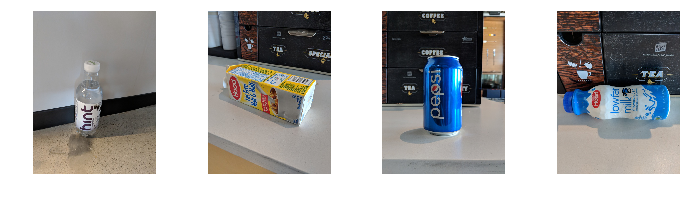

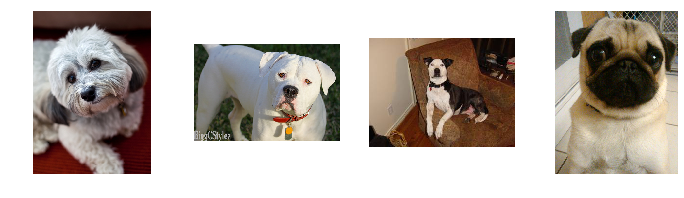

In [81]:
fridge_object_examples = [
    get_image_files(fridge_datapath/'water_bottle')[0],
    get_image_files(fridge_datapath/'carton')[0],
    get_image_files(fridge_datapath/'can')[0],
    get_image_files(fridge_datapath/'milk_bottle')[0],
]
pet_examples = get_image_files(pet_datapath)[:4]

show_im_file(fridge_object_examples)
show_im_file(pet_examples)

In [82]:
fridge_objects = (ImageList.from_folder(fridge_datapath)
                  .split_by_rand_pct(valid_pct=0.2, seed=SEED))
fridge_objects

ItemLists;

Train: ImageList (108 items)
Image (3, 665, 499),Image (3, 665, 499),Image (3, 665, 499),Image (3, 665, 499),Image (3, 665, 499)
Path: /data/home/jumin/git/cvbp/data/fridgeObjects;

Valid: ImageList (26 items)
Image (3, 665, 499),Image (3, 665, 499),Image (3, 665, 499),Image (3, 665, 499),Image (3, 665, 499)
Path: /data/home/jumin/git/cvbp/data/fridgeObjects;

Test: None

In [84]:
pets = (ImageList.from_folder(pet_datapath)
        .split_by_rand_pct(valid_pct=0.2, seed=SEED))
pets

ItemLists;

Train: ImageList (5912 items)
Image (3, 500, 361),Image (3, 333, 500),Image (3, 225, 300),Image (3, 500, 375),Image (3, 500, 375)
Path: /home/jumin/.fastai/data/oxford-iiit-pet/images;

Valid: ImageList (1478 items)
Image (3, 500, 375),Image (3, 500, 500),Image (3, 411, 500),Image (3, 375, 500),Image (3, 500, 375)
Path: /home/jumin/.fastai/data/oxford-iiit-pet/images;

Test: None

In [86]:
import os
from shutil import copyfile
from tempfile import TemporaryDirectory
tmpdir = TemporaryDirectory()

def copy_files(files, dst):
    os.makedirs(dst, exist_ok=True)
    for f in files:
        shutil.copy(f, dst)

data_path = Path(tmpdir.name)/'data'

# Train set
copy_files(fridge_objects.train.items, data_path/'train'/'fridge')
copy_files(pets.train.items[:10], data_path/'train'/'pet')  # initially we add 10 pet images

# Validation set
copy_files(fridge_objects.valid.items, data_path/'valid'/'fridge')
copy_files(pets.valid.items, data_path/'valid'/'pet')

# Test set (unlabeled data. We know this is pet data, but let's pretend we don't know for now)
copy_files(pets.train.items[10:], data_path/'test')

data_path

PosixPath('/tmp/tmpxw19594v/data')

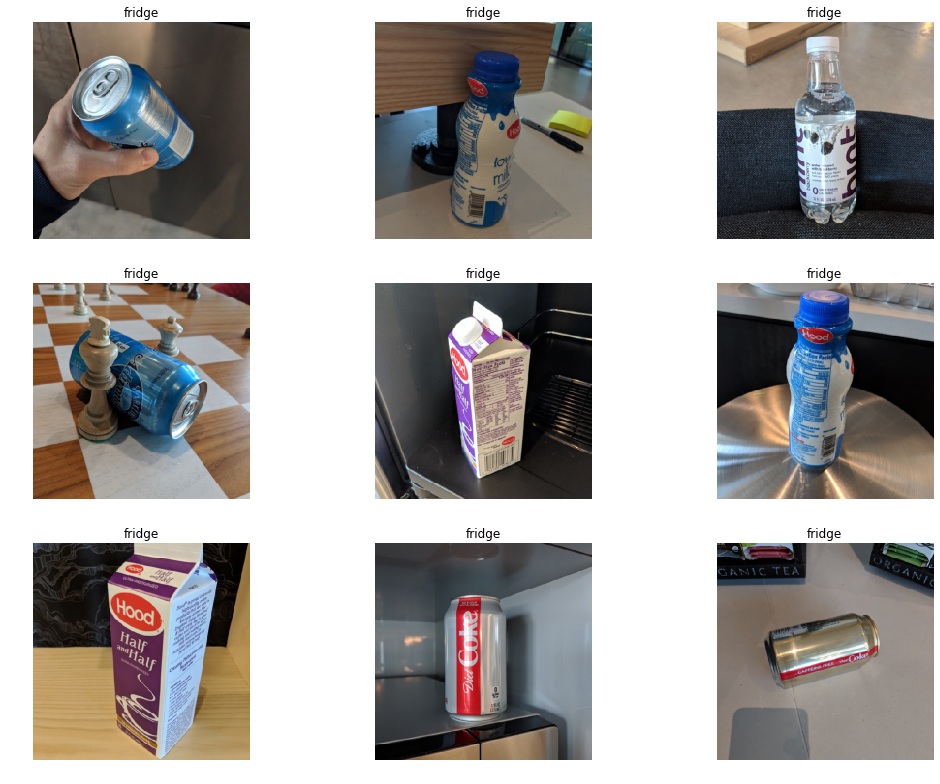

In [90]:
# TODO add seed
data = (ImageList.from_folder(data_path)
        .split_by_folder()
        .label_from_folder()
        .add_test_folder()
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

data.show_batch(rows=3, figsize=(15,11))

In [91]:
print(f'number of classes: {data.c} = {data.classes}')
print(data.batch_stats)

number of classes: 2 = ['fridge', 'pet']
<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (118 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pet,pet,pet,pet,pet
Path: /tmp/tmpxw19594v/data;

Valid: LabelList (1504 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pet,pet,pet,pet,pet
Path: /tmp/tmpxw19594v/data;

Test: LabelList (5902 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /tmp/tmpxw19594v/data>


## 2. Load a pre-trained ImageNet model
## 3. Train the model on *T*
## 4. Score the model on *U* 





For the model, we use a convolutional neural network (CNN). Specifically, we'll use **ResNet50** architecture. You can find more details about ResNet from [here](https://arxiv.org/abs/1512.03385).

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train on [ImageNet](http://www.image-net.org/).

Note, we use a custom callback `TrainMetricsRecorder` to track the accuracy on the training set during training, since fast.ai's default [recorder class](https://docs.fast.ai/basic_train.html#Recorder) only supports tracking accuracy on the validation set.

In [19]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

Unfreeze our CNN since we're training all the layers.

In [20]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.359333,0.954977,0.375000,0.615385,00:07
1,0.881926,0.482578,0.885417,0.961538,00:02
2,0.649298,0.243561,0.906250,0.961538,00:02
3,0.504758,0.151580,0.958333,1.000000,00:02
4,0.394192,0.113908,0.989583,1.000000,00:02


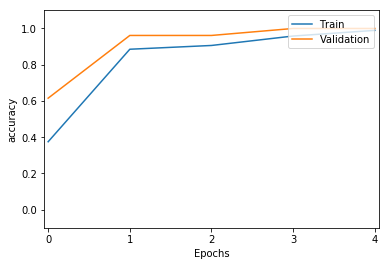

In [21]:
learn.fit(EPOCHS, LEARNING_RATE)

## 3. Negative sampling

In [ ]:
# TODO

Now, analyze the classification results by using `ClassificationInterpretation` module.

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
# Get prediction scores. We convert tensors to numpy array to plot them later.
pred_scores = to_np(interp.probs)

In [25]:
w_results = ResultsWidget(
    dataset=learn.data.valid_ds,
    y_score=pred_scores,
    y_label=[data.classes[x] for x in np.argmax(pred_scores, axis=1)]
)
display(w_results.show())

We can plot precision-recall and ROC curves for each class as well. Please note that these plots are not too interesting here, since the dataset is easy and thus the accuracy is close to 100%.

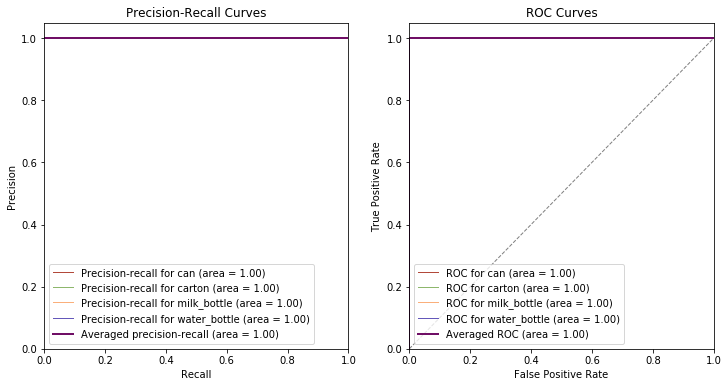

In [26]:
# True labels of the validation set. We convert to numpy array for plotting.
true_labels = to_np(interp.y_true)
plot_pr_roc_curves(true_labels, pred_scores, data.classes)

Let's take a close look how our model confused some of the samples (if any). The most common way to do that is to use a confusion matrix.

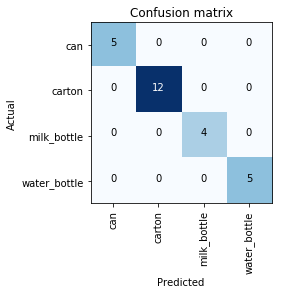

In [27]:
interp.plot_confusion_matrix()

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

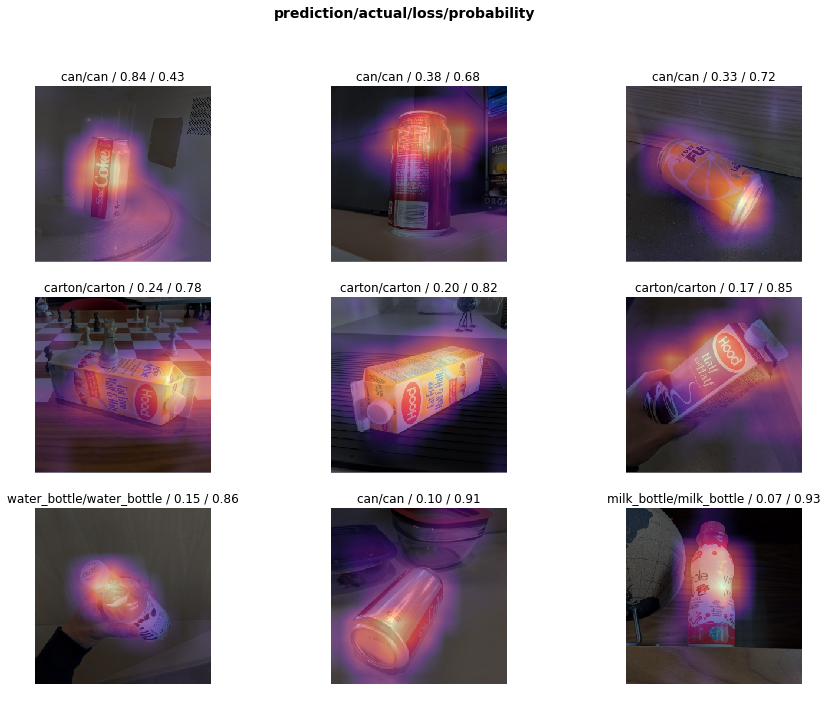

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

That's pretty much it! Now you can bring your own dataset and train your model on them easily. 